# World

In [ ]:
using Rasters, ArchGDAL
using GeoJSON
using Plots
using Images

In [ ]:
using Revise
includet("modules/projection.jl")
includet("modules/affine.jl")
includet("modules/reproject.jl")

In [ ]:
bilinear = ImageTransformations.BSpline(ImageTransformations.Linear())

BSpline(Linear())

## Data

In [ ]:
data_dir = "data"
raster_filepath = joinpath(data_dir, "world.tif")

"data\\world.tif"

In [ ]:
raster = Raster(raster_filepath)

2048×1024×3 Raster{UInt8,3} with dimensions: 
  X Projected{Float64} LinRange{Float64}(-180.0, 179.824, 2048) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected{Float64} LinRange{Float64}(89.8242, -90.0, 1024) ReverseOrdered Regular Intervals crs: WellKnownText,
  Band Categorical{Int64} 1:3 ForwardOrdered
extent: Extent(X = (-180.0, 180.0), Y = (-90.0, 90.0), Band = (1, 3))crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
parent:
[:, :, 1]
             89.8242    89.6484    89.4727  …   -89.6484   -89.8242   -90.0
 -180.0    0x0c       0x0c       0x0c          0xd9       0xd6       0xd0
 -179.824  0x0c       0x0c       0x0c          0xdb       0xd8       0xd2
 -179.648  0x0c       0x0c       0x0c          0xde      

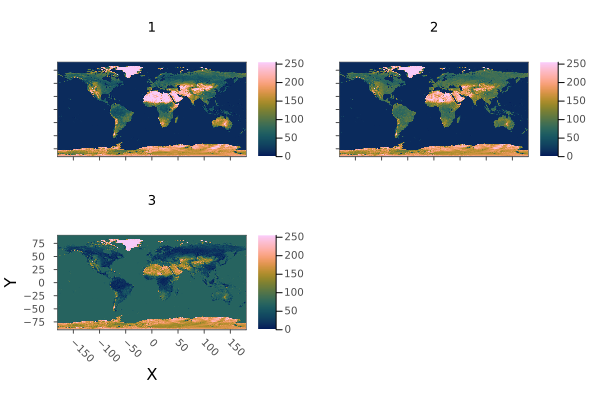

In [ ]:
plot(raster)

In [ ]:
long_min, long_max = extrema(raster.dims[1])
lat_min, lat_max = extrema(raster.dims[2])
println("Dimensions: $long_min $long_max $lat_min $lat_max")
width, height, channels = size(raster)
println("Pixels:     $height × $width × $channels")

Dimensions: -180.0 179.82421875 -90.0 89.82421875
Pixels:     1024 × 2048 × 3


## Image

In [ ]:
output_dir = "images/world_raster";

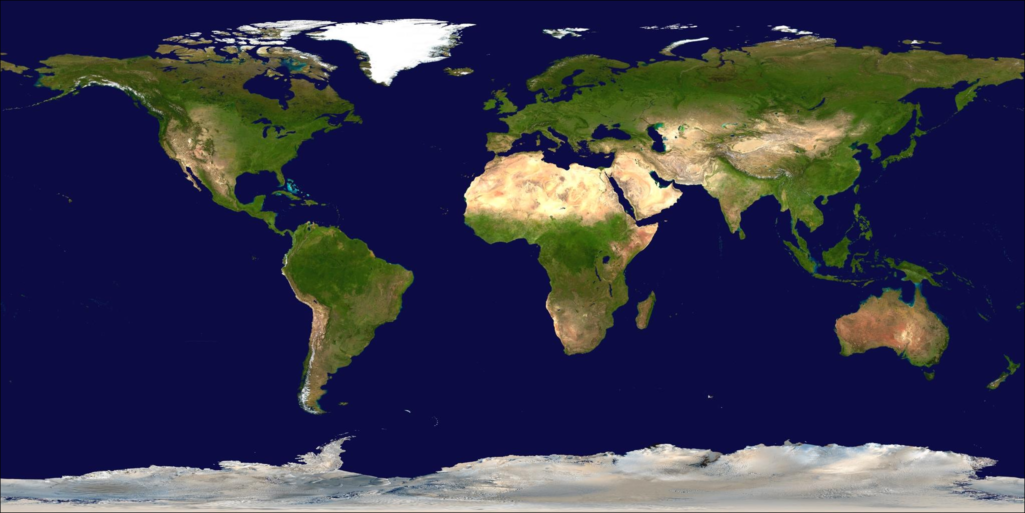

In [ ]:
img_CHW = permutedims(raster.data, (3, 2, 1)) / 0xff
img = colorview(RGB, img_CHW) 

In [ ]:
output_path = joinpath(output_dir, "equirectangular.png")
save(output_path, img)

## Reproject

In [ ]:
src_proj = WorldGeodeticSystem84()

WorldGeodeticSystem84(semi_major_axis=6.378137e6, flattening=1/298.25723)

In [ ]:
height, width = size(img)
src_affine = affine_from_bounds(long_min, lat_min, long_max, lat_max, width, height)

AffineTransform with matrix:
3×3 Matrix{Float64}:
 0.175781   0.0       -180.176
 0.0       -0.175781    90.0
 0.0        0.0          1.0

<b>Cylindrical Equal area</b>

$
\begin{align}
x &= R(\lambda - \lambda_0) \\
y &= R\sin \phi
\end{align}
$

In [ ]:
dest_proj = CylindricalEqualArea(;k=0.001f0) # convert to km

CylindricalEqualArea{Float32}(radius=6.3710085e6, long0=0.0, k=0.001)

In [ ]:
height, width = size(img)
width_dest, height_dest, dest_affine = calculate_suggested_transform(src_proj, dest_proj, width, height, src_affine)
println("Source:      ($height, $width)")
println("Destination: ($height_dest, $width_dest)")

Source:      (1024, 2048)
Destination: (694, 2179)


  0.074760 seconds (6 allocations: 34.563 MiB)


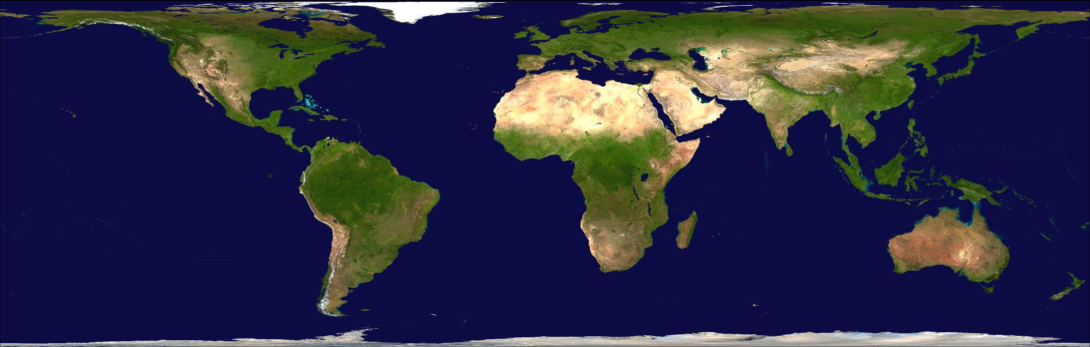

In [ ]:
@time out_img = reproject_warp(
    img, (height_dest - 1, width_dest), src_proj, dest_proj, src_affine, dest_affine; method=bilinear)
out_img = map(clamp01nan, out_img)

In [ ]:
output_path = joinpath(output_dir, "cylindrical_equal_area.png")
save(output_path, out_img)

<b>Mercator</b>

$
\begin{align}
x &= R(\lambda - \lambda_0) \\
y &= R\ln\left(\tan\left(\frac{\pi}{4} + \frac{\phi}{2}\right)\right)
\end{align}
$

In [ ]:
dest_proj = Mercator(;k=0.001) # convert to km

Mercator{Float64}(radius=6.3710085e6, long0=0.0, k=0.001)

In [ ]:
j, i = inv(src_affine)((0, 85))
i_cut = floor(Int, i)
height, width = size(img)
img_cropped = img[i_cut:(height - i_cut), 1:end];

In [ ]:
height, width = size(img_cropped)
crop_affine = affine_from_bounds(long_min, -85.0, long_max, +85.0, width, height)
width_dest, height_dest, dest_affine = calculate_suggested_transform(src_proj, dest_proj, width, height, crop_affine)
println("Source:      ($height, $width)")
println("Destination: ($height_dest, $width_dest)")

Source:      (969, 2048)
Destination: (1599, 1603)


  0.253264 seconds (154.75 k allocations: 68.337 MiB, 28.72% compilation time)


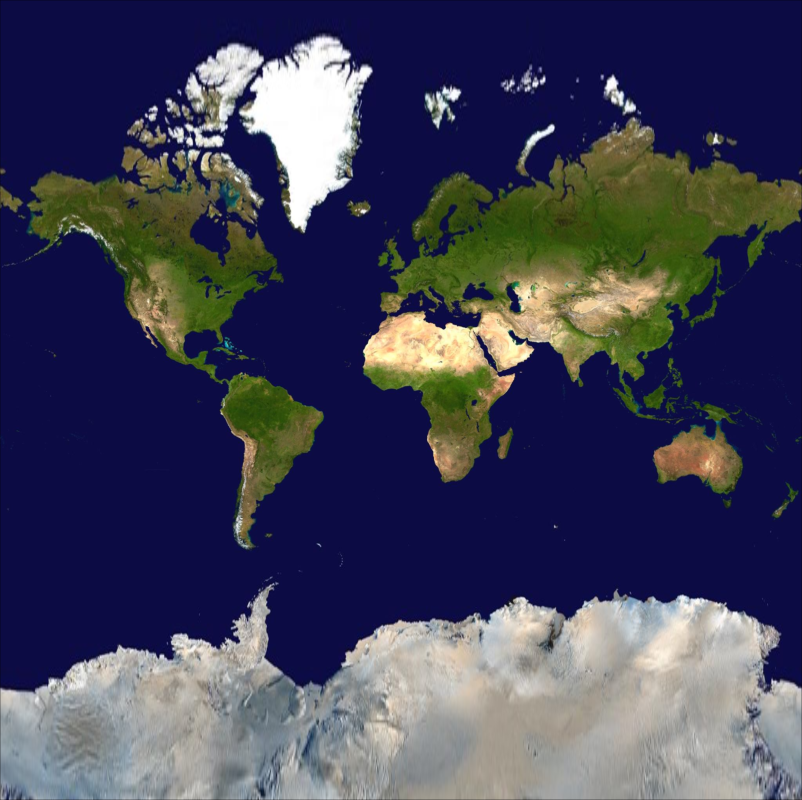

In [ ]:
@time out_img = reproject_warp(
    img_cropped, (height_dest, width_dest), src_proj, dest_proj, crop_affine, dest_affine; method=bilinear)
out_img = map(clamp01nan, out_img)

In [ ]:
output_path = joinpath(output_dir, "mercator.png")
save(output_path, out_img)

<b>TranverseMercator</b>

$
\begin{align}
x &= \frac{1}{2} \log\left( \frac{1+\sin(\lambda - \lambda_0) \cos(\phi)}{1-\sin(\lambda - \lambda_0) \cos(\phi)} \right) \\
y &= R \arctan \left( \tan(\phi)\sec(\lambda -\lambda_0) \right)
\end{align}
$



In [ ]:
dest_proj = TransverseMercator(;k=0.001, long0=0.0) # convert to km

TransverseMercator{Float64}(radius=6.3710085e6, long0=0.0, k=0.001)

In [ ]:
west_boundary = -90.0 + dest_proj.long0
east_boundary = 90.0 + dest_proj.long0
j, i = inv(src_affine)((west_boundary, 0.0))
j_west = floor(Int, j)
j, i = inv(src_affine)((east_boundary, 0.0))
j_east = floor(Int, j)
println(j_west, "-", j_east)
height, width = size(img)
img_cropped = img[1:end, j_west:j_east];
img_back = hcat(img[1:end, j_east:end], img[1:end, 1:j_west]); # back of sphere
img_front = img_cropped; # front of sphere

513-1537


In [ ]:
height, width = size(img_cropped)
crop_affine = affine_from_bounds(west_boundary, lat_min, east_boundary, lat_max, width, height)
width_dest, height_dest, dest_affine = calculate_suggested_transform(src_proj, dest_proj, width, height, crop_affine)
println("Source:      ($height, $width)")
println("Destination: ($height_dest, $width_dest)")

Source:      (1024, 1025)
Destination: (341, 1406)


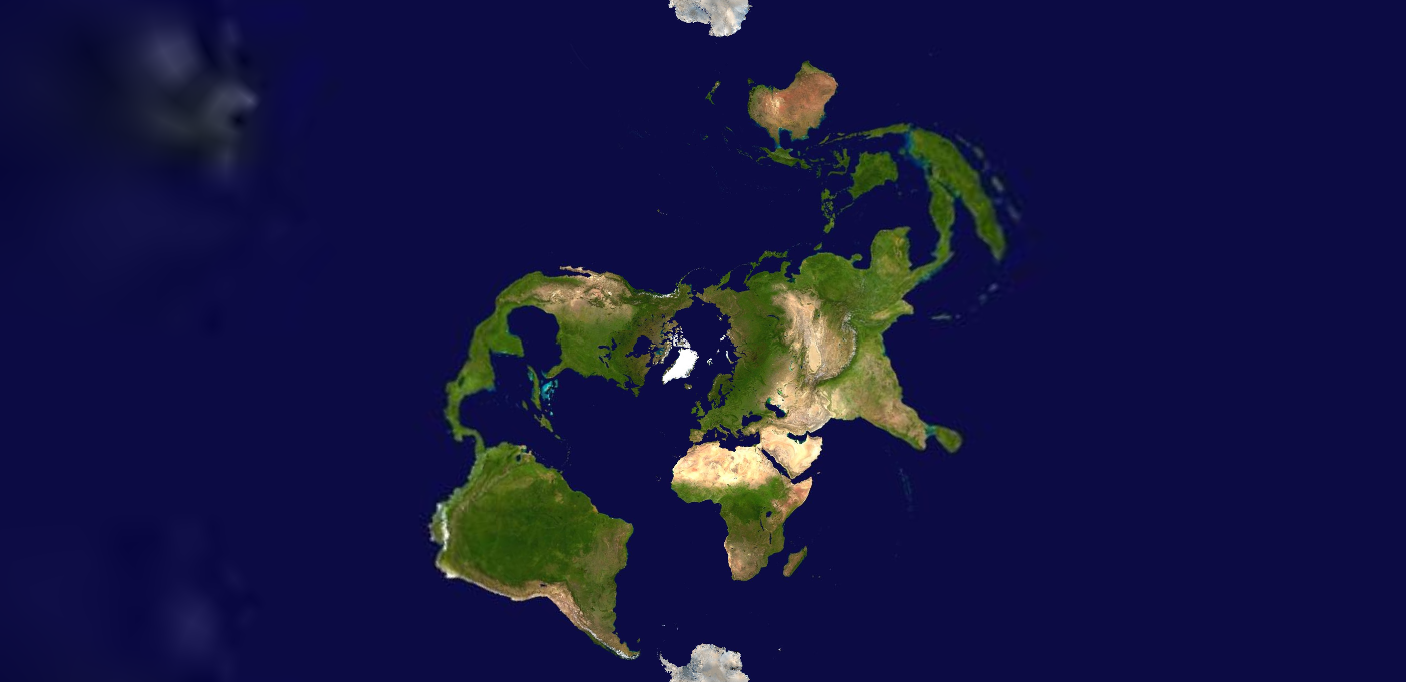

In [ ]:
out_img_front = reproject_warp(
    img_front, (height_dest, width_dest), src_proj, dest_proj, crop_affine, dest_affine; method=bilinear)
out_img_back = reproject_warp(
    img_back, (height_dest, width_dest), src_proj, dest_proj, crop_affine, dest_affine; method=bilinear)
out_img = vcat(out_img_back[end:-1:1, end:-1:1], out_img_front)
out_img = map(clamp01nan, out_img)

In [ ]:
output_path = joinpath(output_dir, "tranverse_mercator_$(dest_proj.long0).png")
save(output_path, out_img)

  0.137468 seconds (35.84 k allocations: 23.956 MiB, 25.74% compilation time)


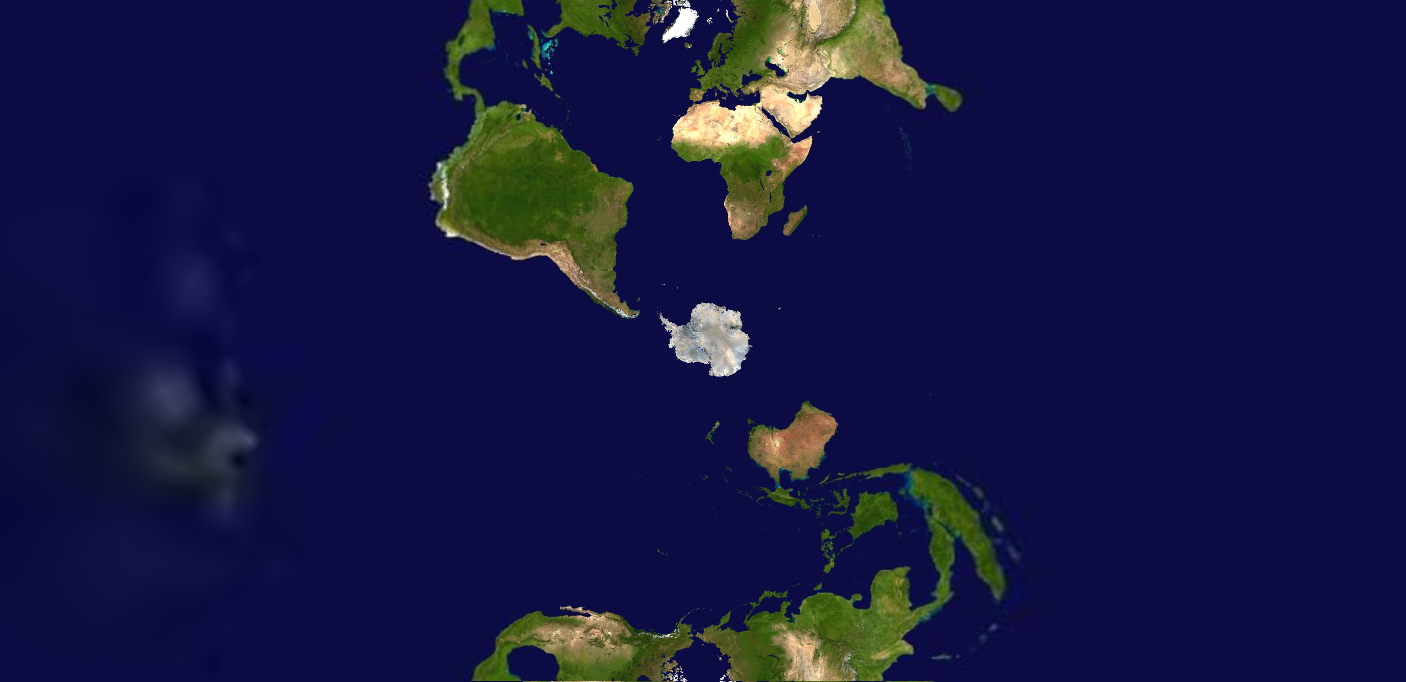

In [ ]:
height, width = size(img)
@time out_img = reproject_warp(
    img, (2 * height_dest, width_dest), src_proj, dest_proj, src_affine, dest_affine; method=bilinear)
out_img = map(clamp01nan, out_img)

Robinson

In [ ]:
dest_proj = Robinson(;k=0.001) # convert to km

Robinson(radius=6.3710085e6, long0=0.0, k=0.001, interpolatorX=CubicSpline{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}([1.0 0.9986 … 0.6213 0.5722; -0.00020655138810036426 -0.0004268972237992455 … -0.010475096751419161 -0.008852829499594515; -2.168404344971009e-20 -4.406916713977622e-5 … 6.860460048657687e-5 0.0002558488498783523; -2.93794447598508e-6 2.897223799243307e-7 … 1.2482949959451696e-5 -1.7056589991890152e-5], 0.0:5.0:90.0), interpolatorY=CubicSpline{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}([0.0 0.062 … 0.9394 0.9761; 0.012400002113304593 0.012399995773390814 … 0.008475618700516885 0.0059183946569951705; -9.26442286059391e-24 -1.2679827558269159e-9 … -0.0001699264116057937 -0.0003415183970985493; -8.453218372179377e-11 4.226609186089726e-10 … -1.143946569951704e-5 2.2767893139903287e-5], 0.0:5.0:90.0))

In [ ]:
height, width = size(img)
width_dest, height_dest, dest_affine = calculate_suggested_transform(src_proj, dest_proj, width, height, src_affine)
println("Source:      ($height, $width)")
println("Destination: ($height_dest, $width_dest)")

Source:      (1024, 2048)
Destination: (1035, 2040)


  0.354183 seconds (98.64 k allocations: 54.419 MiB, 32.36% compilation time)


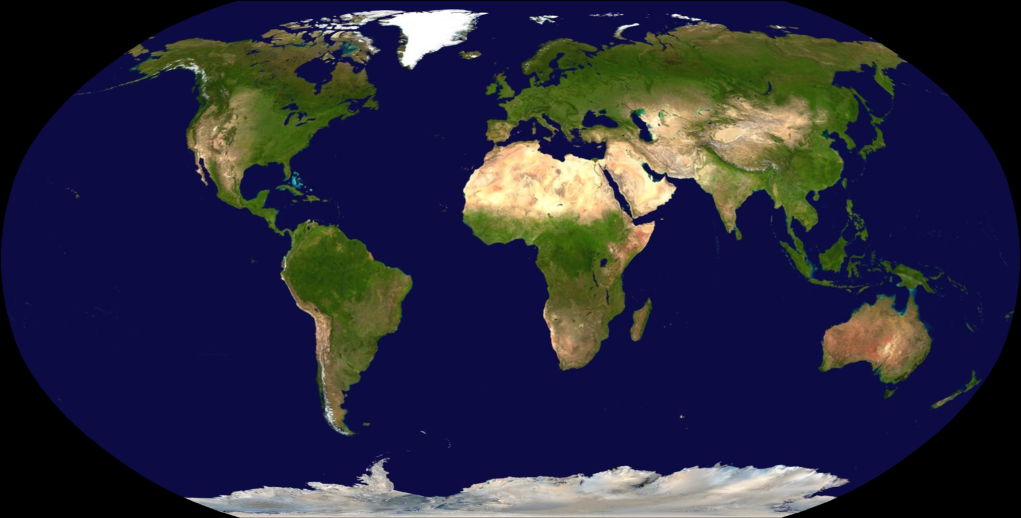

In [ ]:
@time out_img = reproject_warp(
    img, (height_dest, width_dest), src_proj, dest_proj, src_affine, dest_affine; method=bilinear)
out_img = map(clamp01nan, out_img)

In [ ]:
output_path = joinpath(output_dir, "robinson.png")
save(output_path, out_img)